In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics as skm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from fairlearn.datasets import fetch_adult
from fairlearn.reductions import DemographicParity, ErrorRate, GridSearch
from fairlearn.metrics import MetricFrame, selection_rate, count

Parameter set-up. Note that features are independent variables and target is the dependent variable

In [2]:
features = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
            'relationship', 'race', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country']
target = 'income'

# Import the data

The data fetch is not working correctly after the last update. I've created a copy of the data and placed it in the data folder. This is the same data the authors' used in their study and it can be found on the UCI database here: https://archive.ics.uci.edu/ml/datasets/adult

In [3]:
data = pd.read_csv('data/adult_census.csv')

In [4]:
data = data.replace(to_replace={target: {" <=50K": 0, " >50K": 1}}, inplace=False)
data

,Unnamed: 0,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
1,1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
2,2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
3,3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
4,4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32556,32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32557,32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32558,32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


Create the feautres, target, and protected attribute sets

In [5]:
X = data.drop(columns=['sex'], inplace=False)
Y = data[target]
A = data['sex']

dummy encoding for categorical variables

In [6]:
X = pd.get_dummies(X)

standardize variables

In [7]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

encode target

In [8]:
le = LabelEncoder()
Y = le.fit_transform(Y)

# Split Data

Note that this process is somewhat unique because we need to split the third dataset containing the protected attribute. Fairlearn accepts this variable as its own dataset.

In [9]:
X_train, X_test, Y_train, Y_test, A_train, A_test = train_test_split(X_scaled, Y, A, test_size=0.4, random_state=123,
                                                                     stratify=Y)

# Fit an Unmitigated Model

In [10]:
unmitigated_predictor = LogisticRegression(solver="liblinear", fit_intercept=True)
unmitigated_predictor.fit(X_train, Y_train)

LogisticRegression(solver='liblinear')

# Create a FairLearn Metrics Frame

In [11]:
unmit_metric_frame = MetricFrame(metrics={
                                    "accuracy": skm.accuracy_score,
                                    "selection_rate": selection_rate,
                                    "count": count,
                                },
                                sensitive_features=A_test,
                                y_true=Y_test,
                                y_pred=unmitigated_predictor.predict(X_test),
                                )

In [12]:
unmit_metric_frame.overall

accuracy              1.000000
selection_rate        0.240786
count             13024.000000
dtype: float64

In [13]:
unmit_metric_frame.by_group

,accuracy,selection_rate,count
sex,,,
Female,1.0,0.107411,4264.0
Male,1.0,0.305708,8760.0


# Grid Search Bias Mitigation 

set up a grid search for training mitigated models. The grid is used to tune lambda, which impacts the magnitude of bias mitigation applied to the model. This process trains a set of models with varying degrees of mitigation, which creates a set of solutions. 

In [14]:
sweep = GridSearch(
                    LogisticRegression(solver="liblinear", fit_intercept=True),
                    constraints=DemographicParity(),
                    grid_size=50,
                    )

In [15]:
sweep.fit(X_train, Y_train, sensitive_features=A_train)


extract the models

In [16]:
predictors = sweep.predictors_
predictors

[LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegress

Here, the authors will manually call the metrics methods to calculate model results for the solution space. It is a little clumsy, buts it's a product of how the package is set up. The package does not offer an in-house solution to generate the Pareto set from the produced solution space.

In [17]:
errors, disparities = [], []
for m in predictors:

    def classifier(X):
        return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(Y_train), sensitive_features=A_train)

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

Next, the authors use a simple binary non-dominated sort. There are better methods to use out there that can be drawn from other packages and would support more than 2 outcome variables (i.e. many-objective)

In [18]:
non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][
        all_results["disparity"] <= row.disparity
    ]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

In [19]:
non_dominated

[LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegress

Setting up the results, starting with the unmitigated model

In [20]:
predictions = {"unmitigated": unmitigated_predictor.predict(X_test)}
metric_frames = {"unmitigated": unmit_metric_frame}

Gettings metrics frames for each of the non-dominated mitigated model 

In [21]:
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(
        metrics={
            "accuracy": skm.accuracy_score,
            "selection_rate": selection_rate,
            "count": count,
        },
        sensitive_features=A_test,
        y_true=Y_test,
        y_pred=predictions[key],
    )

Here we can see the values from the final results from the models

In [22]:
x = [metric_frame.overall["accuracy"] for metric_frame in metric_frames.values()]
y = [
    metric_frame.difference()["selection_rate"]
    for metric_frame in metric_frames.values()
]

Accuracy

In [23]:
x

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9709766584766585,
 0.9431818181818182]

selection rate

In [24]:
y

[0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.1982968807559519,
 0.11104243234213163,
 0.03486254251372861]

We see that many of the models have the same results as the unmitigates, this is because those models did not recieve a large enough lambda value to improve the model.

Plot the output

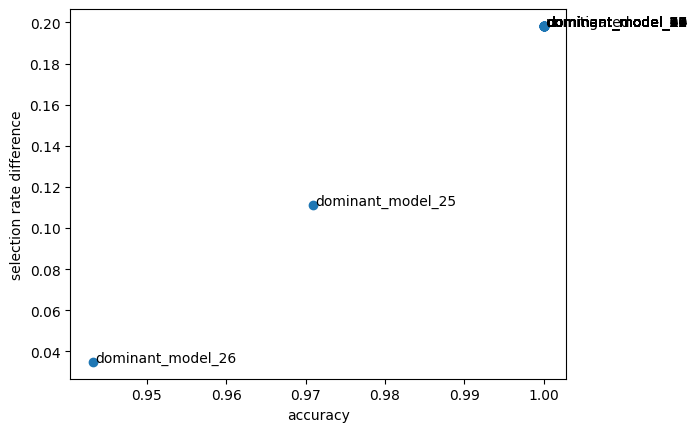

In [25]:
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")
plt.show()